In [18]:

# Import packages that I need to use

import pandas as pd
import yfinance as yf
import re
import matplotlib.pyplot as plt


[*********************100%***********************]  19 of 19 completed


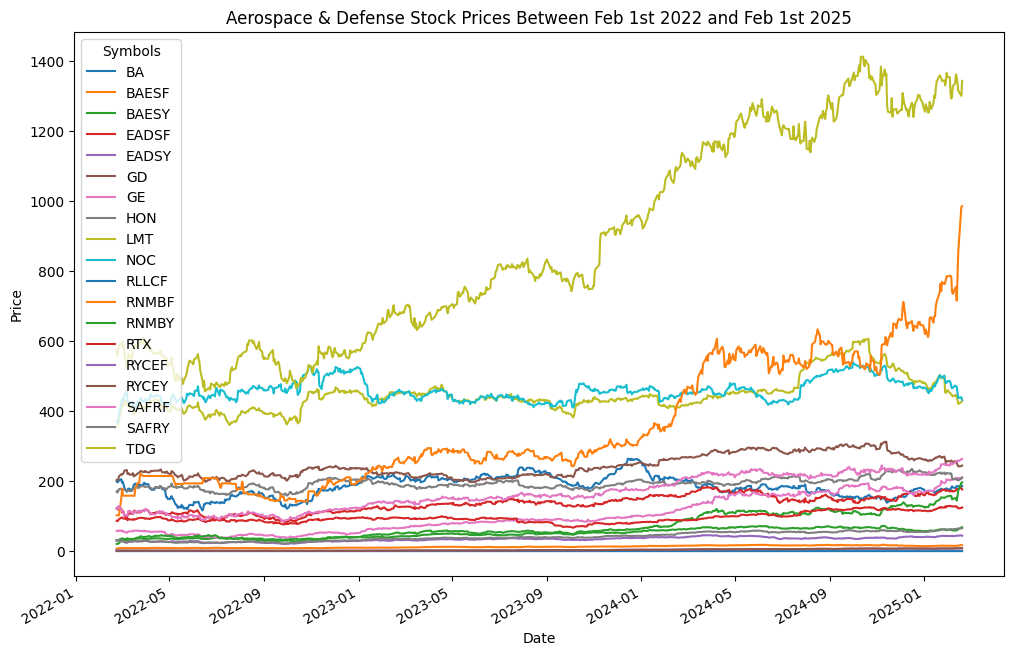

In [19]:
# Gathers all of the defense stock symbols
symbols = df['Symbol'].values[:20]
filtered_tickers = [ticker for ticker in symbols if re.match(r'^[A-Z0-9]+$', ticker)]

data = yf.download(
    filtered_tickers, 
    start="2022-02-20", 
    end="2025-02-20"
)

prices = data["Close"].dropna(how="all")
prices.plot(figsize=(12,8))

plt.title("Aerospace & Defense Stock Prices Between Feb 1st 2022 and Feb 1st 2025")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(title="Symbols")

